## Web Game Chrome Dino

### Step 1

#### Install Dependencies

In [1]:
!pip list

Package                    Version
-------------------------- ------------
agate                      1.7.1
altgraph                   0.17.4
annotated-types            0.6.0
anyio                      4.0.0
argon2-cffi                23.1.0
argon2-cffi-bindings       21.2.0
arrow                      1.3.0
asn1crypto                 1.5.1
asttokens                  2.4.0
async-lru                  2.0.4
attrs                      23.1.0
Automat                    22.10.0
Babel                      2.13.0
backcall                   0.2.0
bcrypt                     4.1.2
beautifulsoup4             4.12.2
bleach                     6.1.0
boto3                      1.34.43
botocore                   1.34.43
certifi                    2023.7.22
cffi                       1.16.0
chardet                    5.2.0
charset-normalizer         3.3.0
chess                      1.10.0
click                      8.1.7
cloudpickle                3.0.0
colorama                   0.4.6
comm            

In [2]:
from mss import mss # screen capture
from pywinauto.application import Application # sending commands
import cv2 # image processing
import numpy as np # Transformational Framework
import pytesseract # OCR for game over detection 
from matplotlib import pyplot as plt # visualize captured frames
import time # time or pauses 
from gymnasium import Env # gym environment
from gymnasium.spaces import Box, Discrete # gym spaces

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
app = Application().connect(title_re=".*chrome://dino/*")

### Step 2

#### Build Environment

In [3]:
# AREA 51 AGENT REWARDS Environment Actions

# """
#     Class WebGame(Env):
#         - __init__(self) -> Setup the environment and observations
#         - step(self, action) -> What is called during the game
#         - reset(self) -> Reset the game
#         - render(self) -> game visualization
#         - close(self) -> close the game
#         - get_observation(self) -> get the obervation part of the game
#         - get_done(self) -> get done part of the game
# """



class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 390, 'left': 630, 'width': 660, 'height': 70}
    
    def seed(self, seed=None):
        pass
        
    def step(self, action):
        action_map = {
            0: '{SPACE}',
            1: '{DOWN}',
            2: 'no_op'
        }
        if action != 2:
            app.top_window().set_focus()
            app.top_window().type_keys(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        truncated = False
        return observation, reward, done, truncated, info
        
    
    def reset(self, seed=None):
        time.sleep(1)
        app.top_window().set_focus()
        app.top_window().click_input(coords=(150, 150))
        app.top_window().type_keys('{SPACE}')  
        if seed is not None:
            self.seed(seed)
        info = {}
        return self.get_observation(), info
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE', 'QaAH', 'GARH']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

#### Test Environment

In [4]:
env =  WebGame()

In [5]:
obs = env.get_observation()

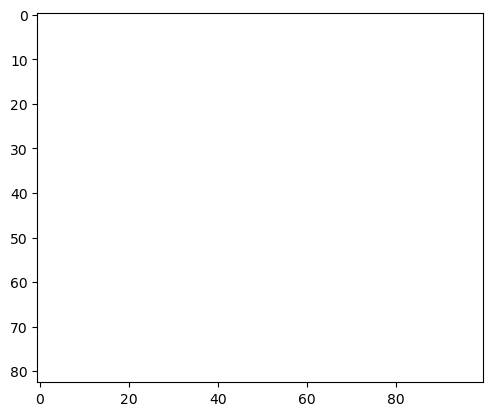

In [6]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2RGB))

In [7]:
done, done_cap = env.get_done()

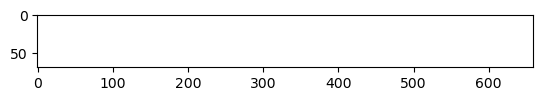

In [8]:
plt.imshow(done_cap)

In [9]:
pytesseract.image_to_string(done_cap)[:4]

''

In [10]:
done

False

In [13]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        observation, reward, done, truncated, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

Total Reward for episode 0 is 20
Total Reward for episode 1 is 27
Total Reward for episode 2 is 22
Total Reward for episode 3 is 38
Total Reward for episode 4 is 34
Total Reward for episode 5 is 20
Total Reward for episode 6 is 20
Total Reward for episode 7 is 25
Total Reward for episode 8 is 25
Total Reward for episode 9 is 20


### Step 3

#### Train Model

##### Create Callback

In [14]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [15]:
env_checker.check_env(env)

In [16]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [17]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [18]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

##### Build DQN

In [19]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [11]:
env = WebGame()

In [ ]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)


In [21]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.2     |
|    ep_rew_mean      | 24.2     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3        |
|    time_elapsed     | 28       |
|    total_timesteps  | 97       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23       |
|    ep_rew_mean      | 23       |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3        |
|    time_elapsed     | 54       |
|    total_timesteps  | 184      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.7     |
|    ep_rew_mean      | 22.7     |
|    exploration_rate | 0.974    |
| time/               |        

In [ ]:
model.load('train/best_model_100000') 

### Step 4

#### Test Model

In [28]:
for episode in range(5): 
    obs_tuple = env.reset()  # or vec_env.reset() if using SB3 VecEnv API
    obs = obs_tuple[0]  # Extracting the observation from the tuple
    done = False
    total_reward = 0
    while not done: 
        action, _states = model.predict(obs)
        observation, reward, done, truncated, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 15
Total Reward for episode 1 is 20
Total Reward for episode 2 is 19
Total Reward for episode 3 is 19
Total Reward for episode 4 is 19
